# Polygenic Risk Scores

The csv files were extracted from this file: `data/ROSMAP_SEAAD_AD_107.rds`, using the following 3 lines of R code:

```R
df <- readRDS("data/ROSMAP_SEAAD_AD_107.rds")
write.csv(df[1], "data/SNPs_metadata.csv", row.names = TRUE)
write.csv(df[2], "data/SNPs.csv", row.names = TRUE)
```

The polygenic risk score $PRS_i$ for sample $i$ is then calculated using:
$$
PRS_i = \sum_{j=1}^M \beta_j \cdot G_{ij}
$$

where $\beta_j$ are the weights from the study (odds-ratio), and $G_{ij}$ the dosage of risk SNP $j$ in sample $i$


Same as the other notebook, but now I use the GWAS data from here to find the betas: https://r12.finngen.fi/pheno/G6_ALZHEIMER
This data was referenced in the earlier meta-analysis paper (Wightman 2021): https://www.nature.com/articles/s41588-021-00921-z



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [ ]:
snps = pd.read_csv("data/SNPs.csv", index_col=0)
snps_meta = pd.read_csv("data/SNPs_metadata.csv", index_col=0).replace({"TRUE": "T"})  # Fix a small mistake in the metadata
weights = weights = pd.read_csv("data/G6_ALZHEIMER.tsv", sep="\t")

In [101]:
weights

,locus_id,good_cs,chrom,pos,pval,mlogp,lead_beta,lead_sebeta,lead_enrichment,lead_af_alt,lead_most_severe_gene,functional_variants_strict,cs_size,cs_log_bayes_factor,all_traits_strict,all_traits_relaxed
0,chr19_44908684_T_C,True,19,44908684,0.000000e+00,1002.10000,0.997145,0.014693,1.290570,0.181294,APOE,chr19_44908684_T_C|missense_variant|APOE|1.0,1,inf,total cholesterol measurement|1;high density l...,Alzheimer disease|1;family history of Alzheime...
1,chr19_44908822_C_T,True,19,44908822,3.436370e-60,59.46390,-0.520524,0.031808,0.561270,0.053040,APOE,chr19_44908822_C_T|missense_variant|APOE|1.0,2,12.328500,total cholesterol measurement|1;coronary arter...,total cholesterol measurement|1;coronary arter...
2,chr2_127135234_C_T,True,2,127135234,2.309400e-21,20.63650,0.128740,0.013566,0.976669,0.373710,NaN,NaN,1,14.235800,family history of Alzheimer’s disease|1;Alzhei...,Alzheimer disease|1;family history of Alzheime...
3,chr11_60173126_T_A,True,11,60173126,1.219550e-16,15.91380,-0.119918,0.014481,0.750194,0.302534,MS4A6A,chr11_60173126_T_A|missense_variant|MS4A6A|1.0,46,9.814570,soluble triggering receptor expressed on myelo...,fibrinogen measurement|1;soluble triggering re...
4,chr21_25897620_C_T,True,21,25897620,5.477720e-14,13.26140,-1.028270,0.136737,11.441200,0.003614,APP,chr21_25897620_C_T|missense_variant|APP|1.0,3,7.174970,NaN,NaN
5,chr19_36672472_T_C,True,19,36672472,2.527550e-13,12.59730,0.912452,0.124695,1000000.000000,0.002440,AC074138.1,NaN,6,6.767190,NaN,NaN
6,chr17_44352876_C_T,True,17,44352876,9.236340e-12,11.03450,0.093453,0.013707,1.238030,0.344857,GRN,chr17_44375697_A_C|missense_variant|ITGA2B|0.7...,14,4.209390,granulins measurement|1;progranulin measuremen...,granulins measurement|1;progranulin measuremen...
7,chr1_207577223_T_C,True,1,207577223,9.963230e-12,11.00160,-0.111269,0.016346,0.991692,0.807749,CR1,chr1_207621975_A_G|missense_variant|CR1|0.961617,21,5.400520,Alzheimer's Disease|1;Alzheimer disease|0.969;...,Alzheimer's Disease|1;Alzheimer disease|0.969;...
8,chr19_41669369_G_T,True,19,41669369,4.736960e-11,10.32450,0.702990,0.106854,1000000.000000,0.003126,CEACAM7,NaN,1,5.386160,NaN,body height|0.402
9,chr7_12226362_C_T,True,7,12226362,1.051650e-10,9.97813,-0.089199,0.013809,0.801784,0.345605,TMEM106B,chr7_12229791_C_G|missense_variant|TMEM106B|0....,83,4.845010,insomnia|1;alkaline phosphatase measurement|1;...,insomnia|1;alkaline phosphatase measurement|1;...


In [103]:
# split locus_id last part "_T_C" into counted and alt
weights["WEIGHT REF"] = weights["locus_id"].str.split("_", expand=True)[2]
weights["WEIGHT ALT"] = weights["locus_id"].str.split("_", expand=True)[3]

In [107]:
# check overlap in pos
overlap_pos = snps_meta[snps_meta["POS"].isin(weights["pos"])]["POS"].values
print(overlap_pos)

overlap = snps_meta[snps_meta["POS"].isin(overlap_pos)].copy()
overlap

weights_overlap = weights[weights["pos"].isin(overlap_pos)]
weights_overlap.set_index("pos", inplace=True)

# and get the weights for these SNPs
overlap["weights"] = weights_overlap.loc[overlap_pos, "lead_beta"].values
overlap["WEIGHT REF"] = weights_overlap.loc[overlap_pos, "WEIGHT REF"].values
overlap["WEIGHT ALT"] = weights_overlap.loc[overlap_pos, "WEIGHT ALT"].values


# if the counted and alt alleles are the same, then we can use the weights directly
# otherwise we need to flip the sign
overlap["sign"] = 1
overlap.loc[overlap["WEIGHT REF"] == overlap["COUNTED"], "sign"] = -1

[ 27607795 144103704  11676714  44352876  44908684 207577223 127135234]


In [109]:
overlap

,CHR,SNP,X.C.M,POS,COUNTED,ALT,weights,WEIGHT REF,WEIGHT ALT,sign
rs11787077,8,chr8:27607795:T:C,0,27607795,T,C,0.083428,T,C,-1
rs34173062,8,chr8:144103704:G:A,0,144103704,G,A,0.158237,G,A,-1
rs7912495,10,chr10:11676714:A:G,0,11676714,A,G,0.079024,A,G,-1
rs5848,17,chr17:44352876:C:T,0,44352876,C,T,0.093453,C,T,-1
rs429358,19,chr19:44908684:T:C,0,44908684,T,C,0.997145,T,C,-1
rs679515,1,chr1:207577223:T:C,0,207577223,T,C,-0.111269,T,C,-1
rs6733839,2,chr2:127135234:C:T,0,127135234,C,T,0.128740,C,T,-1


In [110]:
snps_overlap = snps.loc[overlap.index].copy()

In [111]:
snps_overlap

,H20.33.045,H20.33.044,H21.33.045,H20.33.046,H20.33.014,H21.33.046,H21.33.047,H20.33.011,H21.33.005,H21.33.001,...,R1258062,R8581591,R2750081,R2300123,R2908472,R6808939,R7423003,R4703595,R2213536,R3438797
rs11787077,1.002,1.157,0.350,0.079,1.000,1.152,0.147,1.000,2.000,1.010,...,0.012,1.006,1.000,0.158,1.021,2.000,1.014,0.000,2.000,1.000
rs34173062,1.975,1.895,1.987,1.988,1.978,1.541,1.986,1.996,1.988,1.976,...,1.992,1.832,1.999,1.960,1.986,1.793,1.904,1.967,1.949,1.302
rs7912495,1.995,0.866,1.585,1.136,1.052,1.906,1.399,0.877,1.798,1.392,...,0.743,1.466,1.505,1.007,0.797,0.403,1.953,1.976,1.874,0.732
rs5848,0.531,1.926,1.538,1.362,2.000,0.992,1.968,0.672,1.213,1.000,...,1.633,0.989,0.778,1.000,1.894,1.976,1.966,0.821,1.996,1.644
rs429358,0.925,1.972,0.847,1.993,2.000,2.000,1.997,1.000,1.986,1.978,...,1.986,1.999,1.982,1.999,1.993,1.361,2.000,2.000,2.000,1.997
rs679515,0.170,0.018,0.158,0.168,0.015,0.118,0.021,0.000,0.239,0.000,...,0.998,0.174,0.083,0.072,1.114,0.050,1.110,0.072,0.952,0.109
rs6733839,1.977,1.330,0.850,0.107,2.000,1.367,1.868,1.857,1.343,1.960,...,0.320,1.296,0.027,2.000,1.257,1.727,0.373,1.736,1.501,1.000


In [112]:
weights = overlap

Text(0, 0.5, 'Frequency')

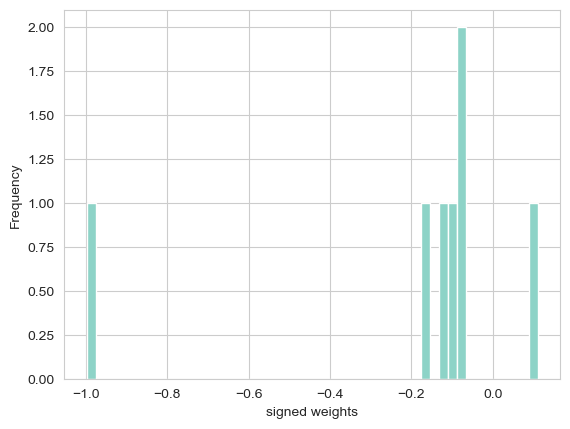

In [119]:
plt.hist((weights["weights"] * weights["sign"]).values.reshape(-1, 1), bins=50)
plt.xlabel("signed weights")
plt.ylabel("Frequency")

In [131]:
# where the sign is negative, the risk allele is not the counted allele
# so for the snps, we have to do 2 - the counted allele to get the risk allele
snps_fixed = snps_overlap.copy()
snps_fixed[weights["sign"] == -1] = 2 - snps_fixed[weights["sign"] == -1]

In [135]:
weights.shape

(7, 10)

In [143]:
prss = (np.array(snps_fixed) * weights["weights"].values.reshape(-1, 1)).sum(axis=0)
prss = pd.Series(prss, index=snps_fixed.columns, name="PRS")

prss.to_csv("data/PRS_FinnGen.csv")

prss

H20.33.045    1.096164
H20.33.044    0.077114
H21.33.045    1.308485
H20.33.046    0.336903
H20.33.014   -0.059045
                ...   
R6808939      0.616547
R7423003      0.214772
R4703595      0.103615
R2213536     -0.033968
R3438797      0.248671
Name: PRS, Length: 2107, dtype: float64

In [134]:
prss_79 = pd.read_csv("data/PRS.csv", index_col=0)
prss_79

,PRS
H20.33.045,-0.139991
H20.33.044,-0.293398
H21.33.045,-0.616018
H20.33.046,-0.012919
H20.33.014,-0.156987
...,...
R6808939,-0.857923
R7423003,0.053622
R4703595,0.016418
R2213536,-0.397821


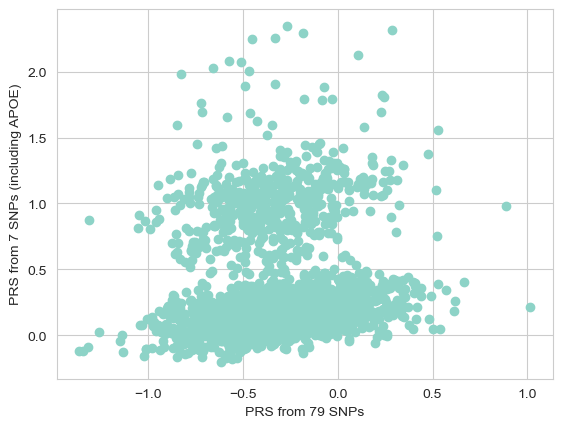

                 PRS
H20.33.045 -0.139991
H20.33.044 -0.293398
H21.33.045 -0.616018
H20.33.046 -0.012919
H20.33.014 -0.156987
...              ...
R6808939   -0.857923
R7423003    0.053622
R4703595    0.016418
R2213536   -0.397821
R3438797    0.044925

[2107 rows x 1 columns] H20.33.045    1.096164
H20.33.044    0.077114
H21.33.045    1.308485
H20.33.046    0.336903
H20.33.014   -0.059045
                ...   
R6808939      0.616547
R7423003      0.214772
R4703595      0.103615
R2213536     -0.033968
R3438797      0.248671
Name: PRS, Length: 2107, dtype: float64


C:\Users\timov\AppData\Local\Temp\ipykernel_6236\1791993691.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(prss_79, prss)


In [142]:
plt.scatter(prss_79, prss)
plt.xlabel("PRS from 79 SNPs")
plt.ylabel("PRS from 7 SNPs (including APOE)")
plt.show()

# check correlation
from scipy.stats import pearsonr
corr, p_value = pearsonr(prss_79, prss)
print(prss_79, prss)

(array([ 328., 1040.,  225.,  107.,  194.,  163.,   22.,   14.,    8.,
           6.]),
 array([-0.2032535 ,  0.05184761,  0.30694872,  0.56204983,  0.81715094,
         1.07225205,  1.32735316,  1.58245427,  1.83755538,  2.09265649,
         2.3477576 ]),
 <BarContainer object of 10 artists>)

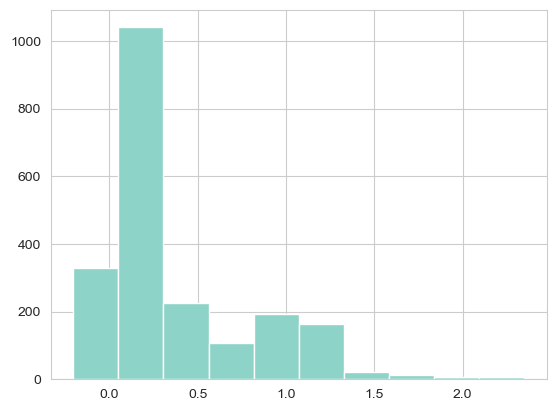

In [126]:
plt.hist(prss)

In [127]:
# validate the PRSs against the clinical metadata

clinical = pd.read_csv("data/ROSMAP_clinical.csv", index_col="individualID")

# check overlap between clinical and PRS
overlap = clinical.index.intersection(prss.index)
print(f"Found {len(overlap)} overlapping samples between clinical and PRS data.")

clinical_overlap = clinical.loc[overlap]
prss_overlap = prss.loc[overlap]

Found 2016 overlapping samples between clinical and PRS data.


In [128]:
clinical.columns

Index(['projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype',
       'age_at_visit_max', 'age_first_ad_dx', 'age_death',
       'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc',
       'cogdx', 'dcfdx_lv'],
      dtype='object')

<Axes: xlabel='apoe_genotype', ylabel='PRS'>

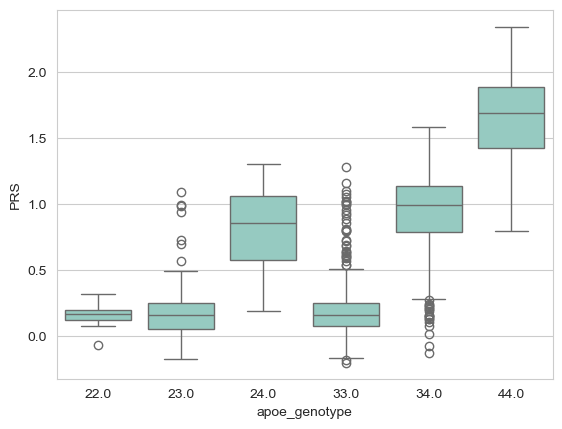

In [130]:
sns.boxplot(y=prss_overlap, x=clinical_overlap["apoe_genotype"])

In [145]:
# use the clinical data to map the Donor IDs to projid, such that we also a a mapping from the projid to the PRS

clinical["projid"]


prss_by_projid = pd.Series(prss_overlap.values, index=clinical["projid"][prss_overlap.index], name="PRS")
prss_by_projid.to_csv("data/PRS_FinnGen_by_projid.csv")

prss_by_projid

projid
10101589    0.226410
86767530    0.204416
9650662     0.175179
50402855    0.935685
20544321    0.203528
              ...   
11699350    1.201366
46757148    1.234011
74494179    0.251216
38113465    0.399526
90214403    1.073861
Name: PRS, Length: 2016, dtype: float64